Thanks for **UPVOTING** this kernel! Trying to become a Kernels Master.

# 1. Introduction

Nowadays one can invest in the loans of other people using online peer-to-peer lending platforms like, for example, the [Lending Club](https://www.lendingclub.com/). On the Lending Club borrowers with higher credit scores (more trustworthy and less risky) get lower interest rates for their loans while borrowers with lower credit scores (less trustworthy and more risky) get higher rates. From the point of view of the investor the loans with higher interest rates are more attractive because they provide higher return on investment (ROI) but on the other hand they pose risks of being not returned at all (defaulted). Therefore, the machine learning model that could predict which of the high interest loans are more likely to be returned, would bring added value by minimizing the associated risks.

<img src="https://i.imgur.com/T4Chhxw.jpg" width="400"/>

For this project I will be using the libraries for data manipulation (Pandas, Numpy), regular expressions (Re), data visualization (Matplotlib, Seaborn), machine learning (Scikit-learn, CatBoost) and statistics (Scipy Stats, Itertools and Statsmodels).

In [13]:
# Downgraded to the previous version due to the critical bug in 0.16
!pip install catboost==0.15
! pip install -U scikit-learn
!pip install feature_engine


SyntaxError: invalid syntax (<ipython-input-13-10522efb4687>, line 4)

In [14]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns
# import feature_engine.missing_data_imputers as mdi
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from catboost import Pool, CatBoostClassifier

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from sklearn.impute import MissingIndicator
from statsmodels.stats.proportion import proportion_confint

In [ ]:
from sklearn.impute import MissingIndicator

# 2. Data preprocessing

## 2.1. Available features

The [Lending Club dataset provided by Wendy Kan from Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data) doesn't contain some of the features that are available for investors like, for example, FICO scores. Therefore, I use the [Lending Club dataset provided by Nathan George](https://www.kaggle.com/wordsforthewise/lending-club) that has all Lending Club loan features. This dataset contains more than 2 million rows so to reduce the processing times, I only selected the loans issued in 2018 (≈0.5 million rows).

In [15]:
data = pd.read_csv(
    '../input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv',
    parse_dates=['issue_d'], infer_datetime_format=True)
data = data[(data.issue_d >= '2018-01-01 00:00:00') & (data.issue_d < '2019-01-01 00:00:00')]
data = data.reset_index(drop=True)
data.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,130954621,NaN,5000.0,5000.0,5000.0,36 months,20.39,186.82,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,130964697,NaN,15000.0,15000.0,15000.0,36 months,9.92,483.45,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,130955326,NaN,11200.0,11200.0,11200.0,60 months,30.79,367.82,G,G1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,130504052,NaN,25000.0,25000.0,25000.0,60 months,21.85,688.35,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


This dataset contains more than 150 features but some of them are only relevant after the loan is issued and therefore, not available at the moment of investing. To get the list of features that are visible to investors, I use the [Lending Club Data Dictionary provided by Wendy Kan](https://www.kaggle.com/wendykan/lending-club-loan-data) (the sheet called "Browse Notes").

In [16]:
browse_notes = pd.read_excel('https://raw.githubusercontent.com/wendykan/LendingClubPublicData/master/data/LCDataDictionary.xlsx',
                             sheet_name=1)
# browse_notes.head()

The missing lines due to Excel formatting are removed and the feature names are saved in `browse_feat`. Some of them, however, have a different spelling format from the one used in the loan dataset. This format uses capital letters instead of underscores so I identify them using using regular expressions and then correct them. For some features there are whitespaces in front of their names which I remove as well.

In [17]:
browse_feat = browse_notes['BrowseNotesFile'].dropna().values
browse_feat = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in browse_feat]

In [ ]:
browse_feat

Still not all the features from "Browse Notes" `browse_feat` could be matched with the original features `data_feat` so I print out the unmatched features from both lists to see if some of them could be matched manually.

In [18]:
data_feat = data.columns.values
np.setdiff1d(browse_feat, data_feat)

array(['accept_d', 'credit_pull_d', 'effective_int_rate', 'exp_d',
       'exp_default_rate', 'ils_exp_d', 'is_inc_v', 'list_d', 'msa',
       'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
       'mths_since_recent_loan_delinq', 'open_il_6m', 'review_status',
       'review_status_d', 'service_fee_rate', 'verified_status_joint'],
      dtype='<U30')

In [ ]:
# np.setdiff1d(data_feat, browse_feat)

Indeed some of the features are spelled differently but mean the same thing, for example `verified_status_joint` and `verification_status_joint`. So I remove wrong and add correct ones to the list `browse_feat`.

In [19]:

wrong = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
         'mths_since_recent_loan_delinq', 'verified_status_joint']
correct = ['verification_status', 'mths_since_recent_inq','mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

browse_feat = np.setdiff1d(browse_feat, wrong)
browse_feat = np.append(browse_feat, correct)

In [20]:
# data['sec_app_chargeoff_within_12_mths'].unique()[2]
browse_feat

array(['acc_now_delinq', 'acc_open_past_24mths', 'accept_d', 'addr_state',
       'all_util', 'annual_inc', 'annual_inc_joint', 'application_type',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'credit_pull_d', 'delinq_2yrs', 'delinq_amnt', 'desc', 'dti',
       'dti_joint', 'earliest_cr_line', 'effective_int_rate',
       'emp_length', 'emp_title', 'exp_d', 'exp_default_rate',
       'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade',
       'home_ownership', 'id', 'il_util', 'ils_exp_d',
       'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths',
       'installment', 'int_rate', 'list_d', 'loan_amnt', 'max_bal_bc',
       'member_id', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'msa', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_rcnt_il', 'mths_since_recent_bc',
       'mths_since

In [ ]:
# data.sec_app_mths_since_last_major_derog
# data_feat

Finally all matching features are saved in the list `avail_feat` a new DataFrame `X` that only contains these features, is created. It is a good practice to set every newly created DataFrame as a copy in order to avoid hidden chained assignments and `SettingWithCopyWarning` further down the code.

In [21]:
avail_feat = np.intersect1d(browse_feat, data_feat)
avail_feat=np.append(avail_feat,'sec_app_earliest_cr_line')
X = data[avail_feat].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495242 entries, 0 to 495241
Data columns (total 95 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   acc_now_delinq                  495242 non-null  float64
 1   acc_open_past_24mths            495242 non-null  float64
 2   addr_state                      495242 non-null  object 
 3   all_util                        495113 non-null  float64
 4   annual_inc                      495242 non-null  float64
 5   annual_inc_joint                68985 non-null   float64
 6   application_type                495242 non-null  object 
 7   avg_cur_bal                     495202 non-null  float64
 8   bc_open_to_buy                  488654 non-null  float64
 9   bc_util                         488439 non-null  float64
 10  chargeoff_within_12_mths        495242 non-null  float64
 11  collections_12_mths_ex_med      495242 non-null  float64
 12  delinq_2yrs     

The column named loan_status is the target variable  and it has been added to the dataframe X so that if we remove some of the rows during feature engineerinig so it can also be reflected in target variable as well.

In [22]:
len(np.intersect1d(browse_feat,data_feat))

94

In [23]:
X2=X.copy()

In [24]:
X.shape

(495242, 95)

In [25]:
X=pd.concat([X,data['loan_status']],axis=1)

In [ ]:
X.head()

In [26]:
import pandas as pd

In [27]:
data['loan_status'].shape

(495242,)

In [28]:
for i in X.columns:
    if(X[i].dtype=='object'):
        print(i,'-',X[i].nunique())
        

addr_state - 50
application_type - 2
desc - 0
earliest_cr_line - 684
emp_length - 11
emp_title - 129449
grade - 7
home_ownership - 4
id - 495242
initial_list_status - 2
purpose - 13
sub_grade - 35
term - 2
title - 12
url - 495242
verification_status - 3
verification_status_joint - 3
zip_code - 897
sec_app_earliest_cr_line - 645
loan_status - 7


The cardinality in the variable emp_title is very high which might cause overfitting as well as operational errors as some categories under the variable emp_title might only be in the training dataset and some might only be in the test dataset.

In [29]:
temp_df=pd.Series(X['emp_title'].value_counts()/len(X))
temp_df

Teacher                    0.017525
Manager                    0.016170
Owner                      0.011067
Driver                     0.008699
Registered Nurse           0.007336
                             ...   
Finance/Sales Manager      0.000002
Strategic Accounts Mgr     0.000002
Senior DE Underwriter 3    0.000002
Music Composer             0.000002
Outport Clerk              0.000002
Name: emp_title, Length: 129449, dtype: float64

As a result we decide to drop the column emp_title due to its high cardinality and leads to the memory error when creating a contingency table, therefore I shall remove it.

In [30]:
# 495242*0.000002*100
# len(X)
X.drop('emp_title',inplace=True,axis=1)

In [ ]:
X.head()

****## 2.2. Feature types

Let's check the categorical features and see if any of them could be transformed to other types.

In [ ]:
# X['emp_title']
avail_feat

In [31]:
X.select_dtypes('object').head()

,addr_state,application_type,desc,earliest_cr_line,emp_length,grade,home_ownership,id,initial_list_status,purpose,sub_grade,term,title,url,verification_status,verification_status_joint,zip_code,sec_app_earliest_cr_line,loan_status
0,OK,Individual,NaN,Jan-2009,8 years,D,RENT,130954621,w,other,D4,36 months,Other,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,740xx,NaN,Current
1,FL,Individual,NaN,Jul-1998,2 years,B,OWN,130964697,w,debt_consolidation,B2,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,337xx,NaN,Current
2,NH,Joint App,NaN,Jul-2007,< 1 year,G,RENT,130955326,w,medical,G1,60 months,Medical expenses,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx,Feb-2005,Current
3,AL,Individual,NaN,Mar-1995,10+ years,D,MORTGAGE,130504052,w,debt_consolidation,D5,60 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,361xx,NaN,Current
4,WA,Individual,NaN,Jan-1998,9 years,A,RENT,130956066,w,major_purchase,A4,36 months,Major purchase,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,988xx,NaN,Fully Paid


The features `earliest_cr_line` and `sec_app_earliest_cr_line` are dates and their type should be changed to `datetime`. Later they will be transformed to ordinal numeric features by the machine learning model.

In [32]:
X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
X['sec_app_earliest_cr_line'] = pd.to_datetime(X['sec_app_earliest_cr_line'], infer_datetime_format=True)

The features `emp_length` and `id` are numeric and their type should be changed to `float`. In case of `emp_length` I replace the extreme cases of "< 1 year" and "10+ years" with "0 years" and "11 years" respectively to separate these groups from the rest.

In [33]:
X['emp_length'] = X['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
X['emp_length'] = X['emp_length'].str.extract('(\d+)').astype('float')
X['id'] = X['id'].astype('float')

In [34]:
X['emp_length'].head()

0     8.0
1     2.0
2     0.0
3    11.0
4     9.0
Name: emp_length, dtype: float64

## 2.3. Missing values


In [35]:
X['member_id'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: member_id, dtype: float64

In the below part of the code we check the missinig values

In [36]:
nan_mean = X.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

pct_tl_nvr_dlq                    0.000004
avg_cur_bal                       0.000081
all_util                          0.000260
revol_util                        0.001195
dti                               0.002286
mths_since_recent_bc              0.012515
bc_open_to_buy                    0.013303
percent_bc_gt_75                  0.013319
bc_util                           0.013737
num_tl_120dpd_2m                  0.025046
mo_sin_old_il_acct                0.037174
mths_since_rcnt_il                0.037174
emp_length                        0.084781
mths_since_recent_inq             0.123788
il_util                           0.163201
mths_since_last_delinq            0.558620
mths_since_recent_revol_delinq    0.711878
mths_since_last_major_derog       0.768128
mths_since_recent_bc_dlq          0.801895
dti_joint                         0.860704
annual_inc_joint                  0.860704
sec_app_earliest_cr_line          0.860704
verification_status_joint         0.870748
mths_since_

In [37]:
nan_mean = nan_mean[nan_mean != 0].sort_values().index
nan_mean

Index(['pct_tl_nvr_dlq', 'avg_cur_bal', 'all_util', 'revol_util', 'dti',
       'mths_since_recent_bc', 'bc_open_to_buy', 'percent_bc_gt_75', 'bc_util',
       'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'mths_since_rcnt_il',
       'emp_length', 'mths_since_recent_inq', 'il_util',
       'mths_since_last_delinq', 'mths_since_recent_revol_delinq',
       'mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'dti_joint',
       'annual_inc_joint', 'sec_app_earliest_cr_line',
       'verification_status_joint', 'mths_since_last_record', 'member_id',
       'desc'],
      dtype='object')

The features `desc` and `member_id` are completely empty so I remove them.

In [38]:
X.drop(['desc', 'member_id'], axis=1,inplace=True)

In [39]:
# X['sec_app_mths_since_last_major_derog']
X.verification_status_joint.unique()

array([nan, 'Not Verified', 'Verified', 'Source Verified'], dtype=object)

For categorical features  `verification_status_joint` the missing values should be filled with an empty string so these features are placed in the list `fill_empty`.

For some of the numeric features the missing values should be filled using either the maximum value of the respective columns or the mean of the respective column so these features are placed in the list `fill_max_mean`. For example, the feature `mths_since_last_record` indicates the number of months since the last record (like bankruptcy, foreclosure, tax liens, etc.) so if missing, one can assume that no records were made and the number of months since the "last" record should be a maximum but this is only done if the number of missing values in the columns is <5% and if it is more than 5 % then we need to add a missing indicator column as well.

For the rest of the numeric features the missing values should be filled using the minimum value or the mean value of the respective columns so these features are placed in the list `fill_min_mean`. For example, the feature `sec_app_earliest_cr_line` indicates the credit line of the secondary applicant so if it is missing so we can assume that there is no secondary applicant and so we can impute those missing values with the minimum value of column 'sec_app_earliest_cr_line' but if the missing values are very high in the column then we can add missing indicator for those column as well.

In [40]:
fill_empty = ['verification_status_joint']
fill_max_mean = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq']
fill_min_mean =np.setdiff1d(X.columns.values,np.append(fill_empty, fill_max_mean))

X[fill_empty] = X[fill_empty].fillna('')
# X[fill_max] = X[fill_max].fillna(X[fill_max].max())
# X[fill_min] = X[fill_min].fillna(X[fill_min].min())

In [41]:
X['acc_now_delinq'].unique()
X['annual_inc_joint'].min()

5693.51

In [42]:
cols_null_fill_min_mean=[cols for cols in fill_min_mean if(X[cols].isnull().mean()>0)]

missing_min_mean=X[fill_min_mean].isnull().mean()
values_miss=missing_min_mean[missing_min_mean!=0].sort_values()
values_miss


avg_cur_bal                 0.000081
all_util                    0.000260
revol_util                  0.001195
dti                         0.002286
percent_bc_gt_75            0.013319
bc_util                     0.013737
num_tl_120dpd_2m            0.025046
emp_length                  0.084781
il_util                     0.163201
annual_inc_joint            0.860704
dti_joint                   0.860704
sec_app_earliest_cr_line    0.860704
dtype: float64

In [43]:
cols_less_than_5=[cols for cols in cols_null_fill_min_mean if(X[cols].isnull().mean()<=0.05)]

In [44]:
cols_less_than_5

['all_util',
 'avg_cur_bal',
 'bc_util',
 'dti',
 'num_tl_120dpd_2m',
 'percent_bc_gt_75',
 'revol_util']

In [ ]:
cols_less_than_5

In [45]:
X[['all_util','avg_cur_bal','dti','percent_bc_gt_75','revol_util','bc_util']].head()

,all_util,avg_cur_bal,dti,percent_bc_gt_75,revol_util,bc_util
0,58.0,3869.0,21.80,0.0,23.2,23.2
1,51.0,31468.0,18.29,75.0,46.3,74.1
2,84.0,8397.0,43.97,0.0,24.6,66.7
3,90.0,10685.0,12.89,100.0,98.4,98.1
4,1.0,25099.0,0.58,0.0,0.5,0.5


Dropping all the rows from the variables with missing values in fill_min_mean if the missing values are in less than 4% of missing values.

In [46]:
X.dropna(subset=cols_less_than_5,inplace=True)

In [47]:
 X[['all_util','avg_cur_bal','dti','percent_bc_gt_75','revol_util','bc_util','num_tl_120dpd_2m']] =X[['all_util','avg_cur_bal','dti','percent_bc_gt_75','revol_util','bc_util','num_tl_120dpd_2m']].fillna(X[['all_util','avg_cur_bal','dti','percent_bc_gt_75','revol_util','bc_util','num_tl_120dpd_2m']].mean())

In [48]:
X.dropna(subset=['num_tl_120dpd_2m'],inplace=True)

In [49]:
X['emp_length'].head()

0     8.0
1     2.0
2     0.0
3    11.0
4     9.0
Name: emp_length, dtype: float64

In [50]:
import pylab
import scipy.stats as stats

In [ ]:
X.shape

In [51]:
#Random sample imputation for the variable emp_length
from feature_engine.imputation import RandomSampleImputer as rdi

In [53]:
imputer = rdi(variables=['emp_length'])

In [54]:
imputer.fit(X)
X=imputer.transform(X)

In [55]:
X['emp_length'].isnull().sum()

0

In [56]:
X['il_util']=X['il_util'].fillna(X['il_util'].median())

In [57]:
# X['il_util'].head()
X['il_util'].median()

70.0

In [58]:
from feature_engine.imputation import AddMissingIndicator as ami

In [60]:
addBinary_imputer1 = ami(
    variables=['annual_inc_joint','dti_joint','sec_app_earliest_cr_line'])

In [61]:
addBinary_imputer1.fit(X)

AddMissingIndicator(variables=['annual_inc_joint', 'dti_joint',
                               'sec_app_earliest_cr_line'])

In [ ]:
X.shape

In [62]:
addBinary_imputer1.transform(X)

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code,sec_app_earliest_cr_line,loan_status,annual_inc_joint_na,dti_joint_na,sec_app_earliest_cr_line_na
0,0.0,3.0,OK,58.0,50000.0,NaN,Individual,3869.0,384.0,23.2,...,500.0,https://lendingclub.com/browse/loanDetail.acti...,Verified,,740xx,NaT,Current,1,1,1
1,0.0,15.0,FL,51.0,196000.0,NaN,Individual,31468.0,7368.0,74.1,...,52400.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,,337xx,NaT,Current,1,1,1
2,0.0,5.0,NH,84.0,44000.0,81000.0,Joint App,8397.0,632.0,66.7,...,6200.0,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx,2005-02-01,Current,0,0,0
3,0.0,2.0,AL,90.0,65000.0,NaN,Individual,10685.0,63.0,98.1,...,8800.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,,361xx,NaT,Current,1,1,1
4,0.0,3.0,WA,1.0,52000.0,NaN,Individual,25099.0,30359.0,0.5,...,31000.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,,988xx,NaT,Fully Paid,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495236,0.0,2.0,NC,64.0,20000.0,NaN,Individual,9926.0,5000.0,28.6,...,11300.0,https://lendingclub.com/browse/loanDetail.acti...,Verified,,280xx,NaT,Current,1,1,1
495237,0.0,9.0,NV,37.0,60000.0,NaN,Individual,15347.0,9547.0,51.3,...,31500.0,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,,890xx,NaT,Charged Off,1,1,1
495238,0.0,9.0,NJ,61.0,72000.0,NaN,Individual,501.0,836.0,81.0,...,9100.0,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,,071xx,NaT,Late (16-30 days),1,1,1
495240,0.0,11.0,NY,28.0,126000.0,NaN,Individual,8254.0,23906.0,31.1,...,39300.0,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,,125xx,NaT,Current,1,1,1


In [63]:
X[['annual_inc_joint','dti_joint','emp_length','il_util']]

,annual_inc_joint,dti_joint,emp_length,il_util
0,NaN,NaN,8.0,51.0
1,NaN,NaN,2.0,59.0
2,81000.0,31.94,0.0,89.0
3,NaN,NaN,11.0,82.0
4,NaN,NaN,9.0,70.0
...,...,...,...,...
495236,NaN,NaN,11.0,93.0
495237,NaN,NaN,2.0,34.0
495238,NaN,NaN,11.0,70.0
495240,NaN,NaN,11.0,70.0


In [64]:
X['annual_inc_joint'].head()

0        NaN
1        NaN
2    81000.0
3        NaN
4        NaN
Name: annual_inc_joint, dtype: float64

In [65]:
 X[['annual_inc_joint','dti_joint']] = X[['annual_inc_joint','dti_joint']].fillna(X[['annual_inc_joint','dti_joint']].median())

In [66]:
# X['il_util'].unique()
# X['annual_inc_joint_na'].head()
X.columns

Index(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util',
       'annual_inc', 'annual_inc_joint', 'application_type', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'dti_joint', 'earliest_cr_line', 'emp_length', 'fico_range_high',
       'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'id',
       'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m',
       'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt', 'max_bal_bc',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_rcnt_il', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_

In [67]:
X[['annual_inc_joint','dti_joint','emp_length','il_util','sec_app_earliest_cr_line']].isnull().sum()

annual_inc_joint                 0
dti_joint                        0
emp_length                       0
il_util                          0
sec_app_earliest_cr_line    408750
dtype: int64

In [ ]:
X.columns

sec_app_earliest_cr_line=second applicant earliest credit line

In [68]:
X['sec_app_earliest_cr_line']=X['sec_app_earliest_cr_line'].fillna(X['sec_app_earliest_cr_line'].min())

In [69]:
X['sec_app_earliest_cr_line'].dtype

dtype('<M8[ns]')

In [70]:
X['num_tl_120dpd_2m'].unique()

array([0.])

In [71]:
X.drop('num_tl_120dpd_2m',axis=1,inplace=True)

In [72]:
X['avg_cur_bal'].min()

0.0

In [73]:
X['mths_since_last_record'].max()

127.0

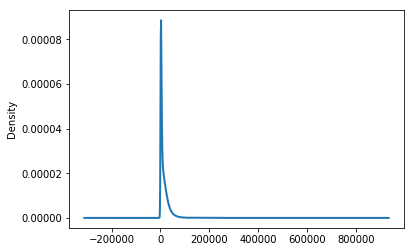

In [74]:
fig=plt.figure()
ax=fig.add_subplot(111)
X['avg_cur_bal'].plot(kind='kde',ax=ax,linewidth=2)

In [75]:
X['avg_cur_bal'].max()

623229.0

In [81]:
X['emp_length'].plot(kind='kde',ax=ax,linewidth=2)
plt.show()

In [82]:
X['emp_length'].median()

6.0

In [83]:
X['emp_length'].mean()

6.141111024548829

In [84]:
fill_min = ['avg_cur_bal','emp_length']
X[fill_min] = X[fill_min].fillna(X[fill_min].min())

In [85]:
# X['annual_inc_joint','dti_joint','sec_app_earliest_cr_line']
# X.columns
fill_min_mean

array(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util',
       'annual_inc', 'annual_inc_joint', 'application_type',
       'avg_cur_bal', 'bc_util', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'dti_joint', 'earliest_cr_line', 'emp_length', 'fico_range_high',
       'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'id',
       'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m',
       'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
       'loan_status', 'max_bal_bc', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
       'num_tl_op_past_12m', 'open_acc', 'open_acc_6m', 'open_il_12m',


In [86]:
X['pct_tl_nvr_dlq'].isnull().sum()

2

In [88]:
from feature_engine.imputation import AddMissingIndicator as ami

In [89]:
addBinary_imputer3 = ami(
    variables=[
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq'])

In [90]:
X[fill_max_mean].isnull().mean()

bc_open_to_buy                    0.000000
mo_sin_old_il_acct                0.037328
mths_since_last_delinq            0.559106
mths_since_last_major_derog       0.772152
mths_since_last_record            0.872316
mths_since_rcnt_il                0.037328
mths_since_recent_bc              0.000000
mths_since_recent_bc_dlq          0.803355
mths_since_recent_inq             0.124999
mths_since_recent_revol_delinq    0.714078
pct_tl_nvr_dlq                    0.000004
dtype: float64

In [91]:
X.dropna(subset=['pct_tl_nvr_dlq'],inplace=True)

In [92]:
X.dropna(subset=['mo_sin_old_il_acct','mths_since_rcnt_il'],inplace=True)

In [93]:
addBinary_imputer3.fit(X)
addBinary_imputer3.transform(X)
X[['mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq']]=X[['mths_since_last_delinq','mths_since_last_major_derog','mths_since_last_record','mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq']].fillna(X[['mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq']].max())

## 2.3. Multicollinearity

Although highly correlated features (*multicollinearity*) aren't a problem for the machine learning models based on decision trees (as used here), these features decrease importances of each other and can make feature analysis more difficult. Therefore, I calculate feature correlations and remove the features with very high correlation coefficients before applying machine learning.

I start with numeric features and before calculating their correlations, it's a good practice to look at the number of their unique values.

In [94]:
num_feat = X.select_dtypes('number').columns
X[num_feat].nunique().sort_values()
        

acc_now_delinq                     1
num_tl_30dpd                       1
inq_last_6mths                     6
pub_rec_bankruptcies               7
open_il_12m                        7
                               ...  
total_il_high_credit_limit    126783
total_bal_ex_mort             137534
tot_cur_bal                   246244
tot_hi_cred_lim               257652
id                            457203
Length: 76, dtype: int64

The feature `num_tl_120dpd_2m` has only one value (a constant) and can be removed. The feature `id` has a unique value for each row and should also be removed, otherwise the model will overfit.

In [95]:
X = X.drop(['num_tl_120dpd_2m', 'id','acc_fnow_delinq'], axis=1, errors='ignore')

X=X.drop(['num_tl_30dpd'],axis=1,errors='ignore')

For all pairs of the numeric features `comb_num_feat` I calculate their Pearson's R correlation coefficient and store it in `corr_num_feat`.

In [96]:
from scipy import stats

Calculate a Spearman correlation coefficient with associated p-value.

The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship 
between two datasets. Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally 
distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 
imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases,
y decreases.

In [97]:
num_feat = X.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = stats.spearmanr(X[comb[0]], X[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


The highly correlated pairs with the absolute value of their correlation coefficient ≥0.9 are printed below.

In [98]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


array([['avg_cur_bal', 'tot_cur_bal'],
       ['fico_range_high', 'fico_range_low'],
       ['funded_amnt', 'installment'],
       ['funded_amnt', 'loan_amnt'],
       ['installment', 'loan_amnt'],
       ['mths_since_last_record', 'pub_rec'],
       ['mths_since_last_record', 'pub_rec_bankruptcies'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0'],
       ['num_sats', 'open_acc'],
       ['pub_rec', 'pub_rec_bankruptcies'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['total_bal_il', 'total_il_high_credit_limit']], dtype='<U30')

In [99]:
high_corr_num1=comb_num_feat[np.abs(corr_num_feat)<=-0.9]
high_corr_num1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


array([], shape=(0, 2), dtype='<U30')

In [100]:
np.unique(high_corr_num[:, 1])

array(['fico_range_low', 'installment', 'loan_amnt',
       'num_rev_tl_bal_gt_0', 'open_acc', 'pub_rec',
       'pub_rec_bankruptcies', 'tot_cur_bal', 'tot_hi_cred_lim',
       'total_il_high_credit_limit'], dtype='<U30')

The first feature (chosen arbitrarily) from each highly correlated feature pair is then removed.

In [101]:
X = X.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

Then I print out the number of unique values for categorical features.

In [102]:
cat_feat = X.select_dtypes('object').columns.values
X[cat_feat].nunique().sort_values()

application_type                  2
initial_list_status               2
term                              2
verification_status               3
home_ownership                    4
verification_status_joint         4
grade                             7
loan_status                       7
title                            12
purpose                          13
sub_grade                        35
addr_state                       50
zip_code                        897
url                          457203
dtype: int64

The feature `url` has a unique value for each entry and should be removed to avoid overfitting.

In [103]:
 X.drop(['url'], axis=1, errors='ignore',inplace=True)

For all pairs of the categorical features `comb_cat_feat` I calculate the Cramer's V correlation coefficient that is expressed through the chi-square statistic $\chi^2$ of the contingency table:

$$ V = \sqrt{ \frac{ \chi^2 }{ n (\text{min}(K_1, K_2) - 1) } } $$

where $n$ is the sum of all elements in the contingency table, $K_1$ and $K_2$ are the dimensions of the contingency table. Note that Pearson's R correlation coefficient or the spearmans correlation coefficient isn't applicable to categorical features and shouldn't be used.

In [104]:
cat_feat = X.select_dtypes('object').columns.values
comb_cat_feat = np.array(list(combinations(cat_feat,2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
    table = pd.pivot_table(X,values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0]/ (table.values.sum() * (np.min(table.shape) - 1) ) )
    corr_cat_feat = np.append(corr_cat_feat, corr)

The highly correlated pairs with the absolute value of their correlation coefficient ≥0.9 are printed below.

In [105]:
high_corr_cat = comb_cat_feat[corr_cat_feat >= 0.9]
high_corr_cat

array([['addr_state', 'zip_code'],
       ['application_type', 'verification_status_joint'],
       ['grade', 'sub_grade'],
       ['purpose', 'title']], dtype='<U25')

This time I remove the second feature from each highly correlated feature pair in order to keep the feature `grade`. It will be used later to select high risk / high interest loans.

In [106]:
X = X.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')

Note that for pairs of a numeric and a categorical feature correlation coefficients can't be interpreted in a meaningful way and therefore shouldn't be used.

In [107]:
datafitting=X.select_dtypes('number')

using IsolationForest to find the outliers

In [108]:
 from sklearn.ensemble import IsolationForest
# data=X.dtypes

In [109]:
contamination=0.01
model=IsolationForest(contamination=contamination,n_estimators=500)
model.fit(datafitting)

IsolationForest(contamination=0.01, n_estimators=500)

In [110]:
X.sec_app_earliest_cr_line.dtype

dtype('<M8[ns]')

In [111]:
for cols in datafitting:
    if(X[cols].isnull().sum()>0):
        print(cols)

In [112]:
datafitting['iforest']=pd.Series(model.predict(datafitting))
datafitting['iforest']=datafitting['iforest'].map({1:0,-1:1})
print(datafitting['iforest'].value_counts())

0.0    417791
1.0      4217
Name: iforest, dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [113]:
X=pd.concat([X,datafitting['iforest']],axis=1)

In the below cell we are keeping a copy of the processed data so that if loss out data in the following cells we don't have to run from the start rather we can just run the code by taking the copy of the processed data.

In [114]:
X1=X.copy()

In [115]:
X1.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,bc_open_to_buy,bc_util,chargeoff_within_12_mths,...,total_acc,total_bal_ex_mort,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rev_hi_lim,verification_status,sec_app_earliest_cr_line,loan_status,iforest
0,0.0,3.0,OK,58.0,50000.0,115000.0,Individual,384.0,23.2,1.0,...,18.0,19344.0,500.0,0.0,27820.0,500.0,Verified,1954-12-01,Current,0.0
1,0.0,15.0,FL,51.0,196000.0,115000.0,Individual,7368.0,74.1,0.0,...,53.0,137713.0,28500.0,1.0,147178.0,52400.0,Source Verified,1954-12-01,Current,0.0
2,0.0,5.0,NH,84.0,44000.0,81000.0,Joint App,632.0,66.7,0.0,...,14.0,67173.0,1900.0,1.0,74167.0,6200.0,Not Verified,2005-02-01,Current,0.0
3,0.0,2.0,AL,90.0,65000.0,115000.0,Individual,63.0,98.1,0.0,...,16.0,17039.0,3300.0,3.0,10220.0,8800.0,Source Verified,1954-12-01,Current,0.0
4,0.0,3.0,WA,1.0,52000.0,115000.0,Individual,30359.0,0.5,0.0,...,30.0,141.0,30500.0,2.0,0.0,31000.0,Source Verified,1954-12-01,Fully Paid,0.0


In [116]:
# X.to_csv("modified_lending_club_data3.csv")

In [117]:
# X1=pd.read_csv('../input/modified-lending-club-data3/modified_lending_club_data3.csv')

In [118]:
X1.sec_app_earliest_cr_line.dtype


dtype('<M8[ns]')

## 2.4. Target feature

The target feature for this dataset is an indicator if the loan is good (1) or bad (0). To identify good loans, I use their loan statuses and print their counts below. The description for each status is provided by the Lending Club:

- Current: Loan is up to date on all outstanding payments.
- In Grace Period: Loan is past due but within the 15-day grace period.
- Late (16-30): Loan has not been current for 16 to 30 days.
- Late (31-120): Loan has not been current for 31 to 120 days.
- Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
- Default: Loan has not been current for an extended period of time.
- Charged Off: Loan for which there is no longer a reasonable expectation of further payments.

In the below cell we are dropping all the values which are 1 because the value 1 is an indicator for outliers

In [119]:
X1.drop(X1[X1.iforest==1].index,axis=0,inplace=True)

In [120]:
X1.drop(['iforest'],axis=1,inplace=True)

The loans with the statuses `Current` and `Fully Paid` are definitely considered good. The loans with the statuses `In Grace Period` can be considered good or not depending on strictness of the investor. In this project I consider them as good loans. All the other statuses are considered as bad loans. Note that this dataset is highly imbalanced with the minority class being 0.037 of the majority class.

In [121]:
y = X1['loan_status'].copy()
y = y.isin(['Current', 'Fully Paid', 'In Grace Period']).astype('int')

# 3. Modelling approach

As mentioned in the beginning, the goal of this project is to predict good loans among the high risk / high interest loans. The Lending Club has two features: 1) `grade` that assigns risk levels to loans ("A" for the lowest risk, "E" for the highest risk); 2) `int_rate` that assigns the interest rate according to the risk level (lowest rates for the grade "A", highest rates for the grade "E"). Therefore, for the modelling dataset `X_mod` I choose only the loans with the grade "E" and remove the features `grade` and `int_rate` since the latter is correlated with `grade` by design.

The modelling dataset is then split into training, validation and testing parts. The validation dataset will be used to adjust some of the hyperparameters such as number of iterations, precision/recall. Both splits are stratified to ensure similar distribution of classes and to avoid one of the classes being left out in the resulting splits. The latter could happen especially in the case of highly imbalanced datasets. The parameter `random_state=0` is added for the reproducibility of results.

In [122]:
X1.drop('loan_status',axis=1,inplace=True)

In [123]:
X_mod = X1[X1.grade == 'E'].copy()
X_mod = X_mod.drop(['grade', 'int_rate'], axis=1, errors='ignore')
y_mod = y[X_mod.index]

X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, stratify=y_mod, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)

For modelling I use [CatBoost](https://catboost.ai/) - a gradient boosting library based on decision trees. CatBoost is very efficient for datasets that contain categorical features with many categories. Instead of traditional one-hot encoding that generates a lot of features and makes gradient boosting of shallow decision tress difficult, CatBoost uses mean encoding that replaces each categorical feature with only one numerical feature. More about mean encoding can be found in [this video](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv).

Before fitting the model I transform the datasets and their targets into the CatBoost objects `Pool()`. The model is defined using the object `CatBoostClassifier()` with several parameters. In `CatBoostClassifier()` the optimal value for the `learning_rate` is calculated automatically for the chosen `iterations` but it's not always the best value. Therefore, I set it to the quite small value 0.03 to ensure good convergence. The parameter `iterations` is set to 1000 so that the model would converge even with such a small learning rate. Another parameter `early_stopping_rounds` is set to 100 (0.1 of the parameter `iterations`) to stop the training and to save time if overfitting is observed. Since the dataset is highly imbalanced, the ratio of two classes `n[0] / n[1]` is passed to the parameter `class_weights`. Using class weights here is equivalent to random oversampling. Note that the final model will be defined not by the last iteration but by the best error score on the evaluation dataset. One can see this optimal point on the CatBoost plot (only visible in the Edit mode of the notebook).
pool is a faster way of passing data to catboost algorithms like catboostregressor,catboostclassifier

In [125]:
cat_feat_ind=[]
for cols in X_train.columns:
    if(X_train[cols].dtypes=='object'):
        cat_feat_ind.append(cols)

In [126]:
# cat_feat_ind = (X_train.dtypes == 'object').nonzero()[0]
pool_train = Pool(X_train, y_train, cat_features=cat_feat_ind)
pool_val = Pool(X_val, y_val, cat_features=cat_feat_ind)
pool_test = Pool(X_test, cat_features=cat_feat_ind)

n = y_train.value_counts()
model = CatBoostClassifier(learning_rate=0.03,
                           iterations=800,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]],
                           verbose=False,
                           random_state=0)
model.fit(pool_train, eval_set=pool_val, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Since the validation dataset was used to tune hyperparameters (the number of iterations), I predict targets for the testing dataset which the model hasn't seen yet. The metrics reported here are accuracy, precision and recall. They all have sensible values which is also confirmed by the confusion matrix shown below.

In [127]:
from pandas.core.ops import roperator

Accuracy (test): 0.651
Precision (test): 0.927
Recall (test): 0.670


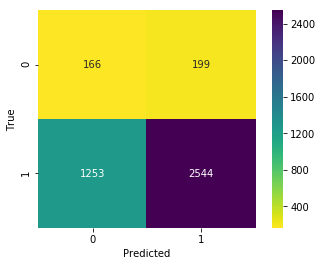

In [128]:
y_pred_test = model.predict(pool_test)
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

cm = confusion_matrix(y_test, y_pred_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

From the confusion matrix it is clear that the model tries to predict both classes and doesn't prefer one over the other due to their imbalance. The latter is a common mistake and if you see accuracy scores without the confusion matrix, be very skeptical about those results. If over-/undersampling isn't applied for imbalanced classes, the classifier will opt for the constant prediction in favor of the majority class. In this case the accuracy for this testing dataset will be quite high 0.912 (see below), although this classifier doesn't have any predictive power! This skewness in class predictions is very visible on the confusion matrix.

Accuracy (constant prediction): 0.912
Precision (constant prediction): 0.912
Recall (constant prediction): 1.000


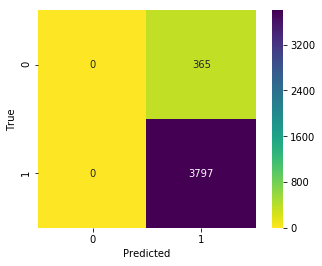

In [129]:
y_pred_const = np.ones(y_test.size)

acc = accuracy_score(y_test, y_pred_const)
prec = precision_score(y_test, y_pred_const)
rec = recall_score(y_test, y_pred_const)
print(f'''Accuracy (constant prediction): {acc:.3f}
Precision (constant prediction): {prec:.3f}
Recall (constant prediction): {rec:.3f}''')

cm = confusion_matrix(y_test, y_pred_const)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

# 4. Feature importances

During the early draft of this project the analysis of feature importances helped me to realize that the [Lending Club dataset provided by Wendy Kan from Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data) was actually including features that aren't available for investors. So I decided to include this analysis here in case someone finds it useful.

Among all features I selected 10 with the largest importance values (see below). The top 3 features are `loan_amnt`, `revol_bal` and `revol_util`. The importances of `mths_since_recent_inq` and `revol_util`, however, are quite close to each other and the rest of the features so this ranking might slightly change for a different train-test split.

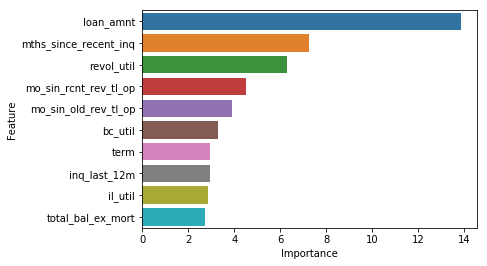

In [130]:
feat = model.feature_names_
imp = model.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);

In gradient boosting the importances of highly correlated features usually split between them. From the correlation heatmap (see below) the feature `revol_util` (top 3) is quite highly correlated with `bc_util` (top 5) which leads to the decreased importance of `revol_util`.

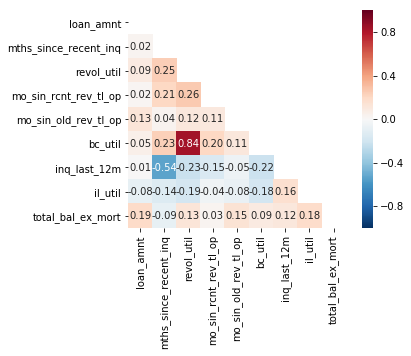

In [131]:
corr = X_mod[df['Feature'].values].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, square=True, cmap='RdBu_r', vmin=-1, vmax=1, annot=True, fmt='.2f');

It is also useful to look at the distributions of the features to see how their values influence predictions.

From the histogram for the feature `loan_amnt` (top 1) the loan is more likely to be returned (good loans) if the loan amount is lower. This makes sense because smaller loan amounts usually have smaller monthly installments that are easier to pay.

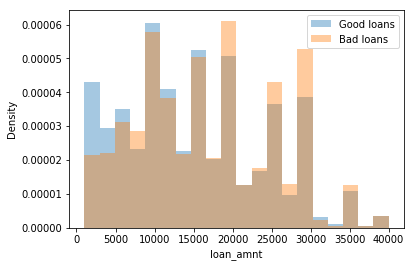

In [132]:
good = X_mod.loc[y_mod == 1, 'loan_amnt']
bad = X_mod.loc[y_mod == 0, 'loan_amnt']

bins = 20

sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

From the histogram for the feature `mths_since_recent_inq` (top 3) the loan is less likely to be returned (bad loans) if the borrower had an inquiry recently. This also makes sense because inquiries are usually done when someone applies for a loan, a credit card, etc. so recent inquiries could indicate bad financial stability of the borrower.

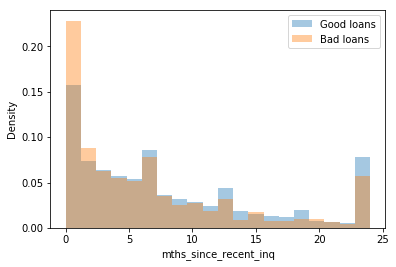

In [133]:
good = X_mod.loc[y_mod == 1, 'mths_since_recent_inq']
bad = X_mod.loc[y_mod == 0, 'mths_since_recent_inq']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

From the histogram for the feature `revol_util` (top 3) the loan is less likely to be returned (bad loans) if the revolving utilization is lower. This actually doesn't make much sense because revolving utilization is the percentage of the used credit on your credit card so higher revolving utilization indicates worse financial stability. Nevertheless, this dataset shows otherwise and it could be an interesting topic for discussion.

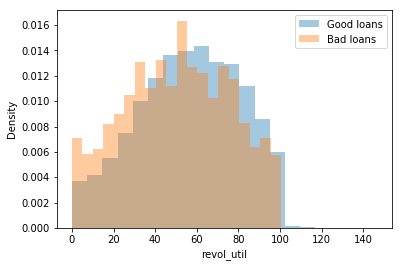

In [134]:
good = X_mod.loc[y_mod == 1, 'revol_util']
bad = X_mod.loc[y_mod == 0, 'revol_util']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

# 5. Model adjustment

The previously reported model was obtained by minimizing both false positive and false negative errors that contribute to precision and recall respectively. In reality, however, one of these errors might have a larger impact so it would be better to optimize for it instead. In case of loan investing, the false positive errors are the number of bad loans that were identified as good so the investor will loose money by investing in them. This is a direct loss and should be avoided. The false negative errors are the number of good loans that were identified as bad so the investor will not earn extra money by not investing in them. This is a missed opportunity and is less critical compared to the direct loss. Therefore, the false positive errors should be decreased (higher precision) even if the false negative errors will be increased (lower recall). The connection between precision and recall can be visualized using the precision-recall curve (see below). To calculate it, one requires probabilities of belonging to class 1 rather than the predicted labels. This precision-recall curve is calculated for the validation dataset because adjusting precision or recall is similar to adjusting hyperparameters. For each precision-recall pair the function `precision_recall_curve()` also returns the corresponding probability threshold. This threshold is the actual hyperparameter that will be used to obtain the best precision.

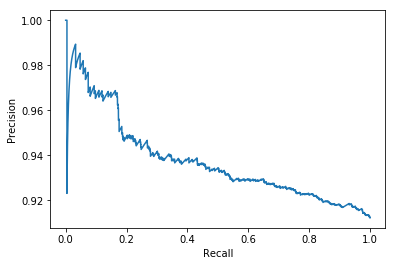

In [135]:
y_proba_val = model.predict_proba(pool_val)[:, 1]
p_val, r_val, t_val = precision_recall_curve(y_val, y_proba_val)
plt.plot(r_val, p_val)
plt.xlabel('Recall')

plt.ylabel('Precision');

In [136]:
y_proba_val

array([0.47076046, 0.47858934, 0.41261295, ..., 0.58455295, 0.56528584,
       0.54464093])

From the precision-recall curve the best precision is 1 but then the recall would be extremely low so in the end the model might not predict good loans at all. Therefore, I exclude 1 from the precision array and find its maximum. The threshold array `t` returned by `precision_recall_curve()` is missing the threshold 0 in the beginning so I add it to match the dimension of the precision array `p`. Then I find the threshold that correspond to the maximum precision and recalculate the predicted labels. The obtained precision score for the adjusted labels is indeed the maximum (excluding 1) as can be seen from the precision-recall curve.

In [137]:
p_max = p_val[p_val != 1].max()
t_all = np.insert(t_val, 0, 0)
t_adj_val = t_all[p_val == p_max]
y_adj_val = (y_proba_val > t_adj_val).astype(int)
p_adj_val = precision_score(y_val, y_adj_val)
print(f'Adjusted precision (validation): {p_adj_val:.3f}')

Adjusted precision (validation): 0.989


Note that the above precision-recall curve is only valid for this particular validation dataset. So the precision that corresponds to the adjusted threshold on this dataset will be different from the precision for the same threshold on a different dataset. If these two datasets, however, are sampled from the same population, the precision values will have a certain spread that can be estimated using confidence intervals. Since precision is a proportion, it has the binomial distribution and its confidence interval can be conveniently calculated using the Statsmodels method `proportion_confint()`. Typically 95% confidence interval is calculated which corresponds to the parameter `alpha=0.05`. This means that the precision will be within this interval in 95% of cases. Since the obtained precision values are close to 1 (edge case), it's better to use the Wilson interval by setting the parameter `method='wilson'`. Also one should carefully calculate the denominator for adjusted precision `n` by taking the total amount of predicted good loans (class 1) after adjustment and not before.

In [138]:
n = y_adj_val.sum()
ci = proportion_confint(p_adj_val * n, n, alpha=0.05, method='wilson')
print(f'95% confidence interval for adjusted precision: [{ci[0]:.3f}, {ci[1]:.3f}]')

95% confidence interval for adjusted precision: [0.942, 0.998]


Finally by using the adjusted threshold on the testing dataset, the adjusted precision 0.939 is indeed within the above 95% confidence interval. Note, however, that the recall is significantly decreased from 0.632 to 0.068 but the precision only increased from 0.931 to 0.939. Of course the gain in precision depends on the train-test split and for a different testing dataset can be closer to the right boundary of the confidence interval. Getting higher values than that, however, is unlikely.

Adjusted precision (test): 0.962
Adjusted recall (test): 0.027


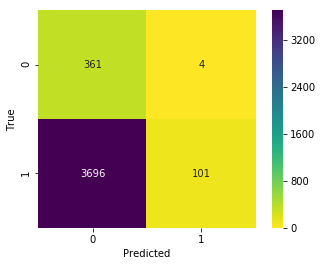

In [139]:
y_proba_test = model.predict_proba(pool_test)[:, 1]
y_adj_test = (y_proba_test > t_adj_val).astype(int)
p_adj_test = precision_score(y_test, y_adj_test)

r_adj_test = recall_score(y_test, y_adj_test)
print(f'''Adjusted precision (test): {p_adj_test:.3f}
Adjusted recall (test): {r_adj_test:.3f}''')

cm_test = confusion_matrix(y_test, y_adj_test)
ax = sns.heatmap(cm_test, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

# Following are all the steps which the investor has to run to complete all the preprocessing steps for the lenders data before using that data for making predictions in the ML model

first the investor needs to add the data to the kaggle jupyter notebook from the option mentioned on the right side which says "+ Add data" and then store the dataset into a variable called yk

In [ ]:
yk=pd.read_csv(" ")#enter the name of you csv file in the double inverted commas ,for excel files use pd.read_excel(" ")

Note that the data should be a proper which means it should contain the same attributes as the variabe X had in the beginning of the notebook

In [ ]:
data_feat = yk.columns.values
np.setdiff1d(browse_feat, data_feat)

wrong = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
         'mths_since_recent_loan_delinq', 'verified_status_joint']
correct = ['verification_status', 'mths_since_recent_inq','mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

browse_feat = np.setdiff1d(browse_feat, wrong)
browse_feat = np.append(browse_feat, correct)
avail_feat = np.intersect1d(browse_feat, data_feat)
avail_feat=np.append(avail_feat,'sec_app_earliest_cr_line')
X = data[avail_feat].copy()
X.info()


In [ ]:
yk=X[1:2]

In [ ]:
yk

In [ ]:
yk=pd.concat([yk,data['loan_status']],axis=1)
yk.drop('emp_title',inplace=True,axis=1)
yk['earliest_cr_line'] = pd.to_datetime(yk['earliest_cr_line'], infer_datetime_format=True)
yk['sec_app_earliest_cr_line'] = pd.to_datetime(yk['sec_app_earliest_cr_line'], infer_datetime_format=True)
yk['emp_length'] = yk['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
yk['emp_length'] = yk['emp_length'].str.extract('(\d+)').astype('float')
yk['id'] = yk['id'].astype('float')
yk = yk.drop(['desc', 'member_id'], axis=1, errors='ignore')
yk[['all_util','avg_cur_bal','dti','percent_bc_gt_75','revol_util','bc_util','num_tl_120dpd_2m']] =yk[['all_util','avg_cur_bal','dti','percent_bc_gt_75','revol_util','bc_util','num_tl_120dpd_2m']].fillna(X[['all_util','avg_cur_bal','dti','percent_bc_gt_75','revol_util','bc_util','num_tl_120dpd_2m']].mean())
yk=imputer.transform(yk)
yk['il_util']=yk['il_util'].fillna(yk['il_util'].median())
addBinary_imputer1.transform(yk)
yk[['annual_inc_joint','dti_joint']] = yk[['annual_inc_joint','dti_joint']].fillna(yk[['annual_inc_joint','dti_joint']].median())
addBinary_imputer2.transform(yk)
yk['sec_app_earliest_cr_line']=yk['sec_app_earliest_cr_line'].fillna(X['sec_app_earliest_cr_line'].min())
yk.drop('num_tl_120dpd_2m',axis=1,inplace=True)
fill_min = ['avg_cur_bal','emp_length']
yk[fill_min] = yk[fill_min].fillna(youou[fill_min].min())
yk['pct_tl_nvr_dlq'].dropna(inplace=True)
yk.dropna(subset=['pct_tl_nvr_dlq'],inplace=True)
yk.dropna(subset=['mo_sin_old_il_acct','mths_since_rcnt_il'],inplace=True)
addBinary_imputer3.fit(yk)
addBinary_imputer3.transform(yk)
yk[['mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq']]=yk[['mths_since_last_delinq','mths_since_last_major_derog','mths_since_last_record','mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq']].fillna(X[['mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq']].max())

In [ ]:
yk = yk.drop(['num_tl_120dpd_2m', 'id','acc_now_delinq'], axis=1, errors='ignore')
yk=yk.drop(['num_tl_30dpd'],axis=1,errors='ignore')
yk = yk.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')
yk.drop(['url'], axis=1, errors='ignore',inplace=True)
yk = yk.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')
yk.drop('loan_status',axis=1,inplace=True)
yk.drop(['grade','int_rate'],axis=1,inplace=True)

In [ ]:
y_proba_test = model.predict_proba(yk)[:, 1]
y_adj_test = (y_proba_test > t_adj_val).astype(int)
y_adj_test